# MNIST Experiment

I'd like to do some research on likiness across networks when learning from different initialization states.

- Visualize and compare the activation values for same layer depths

### Download and/or load MNIST dataset

In [1]:
import numpy
from urllib import request
import gzip
import pickle
import os

filename = [
    ["training_images","train-images-idx3-ubyte.gz"],
    ["test_images","t10k-images-idx3-ubyte.gz"],
    ["training_labels","train-labels-idx1-ubyte.gz"],
    ["test_labels","t10k-labels-idx1-ubyte.gz"]
]

def download_mnist():
    base_url = "http://yann.lecun.com/exdb/mnist/"
    for name in filename:
        print("Downloading " + name[1] + "...")
        request.urlretrieve(base_url + name[1], "./mnist/" + name[1])
    print("Download complete.")

def save_mnist():
    mnist = {}
    for name in filename[:2]:
        with gzip.open("./mnist/" + name[1], "rb") as f:
            mnist[name[0]] = numpy.frombuffer(f.read(), numpy.uint8, offset=16).reshape(-1, 28 * 28)
    for name in filename[-2:]:
        with gzip.open("./mnist/" + name[1], "rb") as f:
            mnist[name[0]] = numpy.frombuffer(f.read(), numpy.uint8, offset=8)
    with open("./mnist/mnist.pkl", "wb") as f:
        pickle.dump(mnist, f)
    print("Save complete.")

def mnist_init():
    if os.path.exists("./mnist/mnist.pkl"):
        print("Pkl detected. Skipping download.")
        return
    download_mnist()
    save_mnist()

def mnist_load():
    with open("./mnist/mnist.pkl", "rb") as f:
        return pickle.load(f)

mnist_init()
mnist_dataset = mnist_load()
training_images = mnist_dataset["training_images"] 
training_labels = mnist_dataset["training_labels"]
test_images = mnist_dataset["test_images"]
test_labels = mnist_dataset["test_labels"]

Pkl detected. Skipping download.


### Set seed and convert dataset to torch loaders

In [2]:
import torch
from torch.utils.data import DataLoader

threads = 32
torch.set_num_threads(threads)
batch_size = 1000
shuffle = True
learning_rate = 0.004
seed = 38734155

# Seed
import random
random.seed(seed)
torch.manual_seed(seed)
numpy.random.seed(seed)

# Training
training_images_tensor = torch.FloatTensor(training_images)
training_labels_tensor = torch.LongTensor(training_labels)
training_dataset = torch.utils.data.TensorDataset(training_images_tensor, training_labels_tensor)
training_loader = torch.utils.data.DataLoader(training_dataset, batch_size=batch_size, shuffle=shuffle)

# Validate
validate_images_tensor = torch.FloatTensor(test_images)
validate_labels_tensor = torch.LongTensor(test_labels)
validate_dataset = torch.utils.data.TensorDataset(validate_images_tensor, validate_labels_tensor)
validate_loader = torch.utils.data.DataLoader(validate_dataset, batch_size=batch_size, shuffle=shuffle)

### Define network architecture, loss function, and optimizer

In [3]:
class Network(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_relu_stack = torch.nn.Sequential(
            torch.nn.Linear(784, 196),
            torch.nn.ReLU(),
            torch.nn.Linear(196, 10),
            torch.nn.ReLU()
        )

    def forward(self, x):
        return self.linear_relu_stack(x)

model = Network()
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.004)

### Define train and validate methods

In [4]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.train()
    avg_loss, avg_accuracy = 0, 0
    for batch, (X, y) in enumerate(dataloader):
        # Forwards pass
        pred = model(X)
        loss = loss_fn(pred, y)
        avg_loss += loss.item()
        avg_accuracy += (pred.argmax(1) == y).type(torch.float).sum().item()

        # Backwards pass
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        # if batch % (size / batch_size / 5) == 0:
        #     loss, current = loss.item(), (batch + 1) * len(X)
        #     print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    avg_loss /= num_batches
    avg_accuracy /= size
    return avg_loss, avg_accuracy

def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    avg_loss, avg_accuracy = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            avg_loss += loss_fn(pred, y).item()
            avg_accuracy += (pred.argmax(1) == y).type(torch.float).sum().item()
    avg_loss /= num_batches
    avg_accuracy /= size
    return avg_loss, avg_accuracy

### Train

In [5]:
epochs = 10
training_loss, training_accuracy = 0, 0
validate_loss, validate_accuracy = 0, 0
for t in range(epochs):
    training_loss, training_accuracy = train(training_loader, model, loss_fn, optimizer)
    validate_loss, validate_accuracy = test(validate_loader, model, loss_fn)
    print(f"E{t+1:02d} [Train/Test] Accuracy: {(100*training_accuracy):>0.1f}%/{(100*validate_accuracy):>0.1f}@{abs((100*training_accuracy)-(100*validate_accuracy)):>0.1f}, Avg loss: {training_loss:>8f}/{validate_loss:>8f}@{abs(training_loss-validate_loss):>8f}")


E01 [Train/Test] Accuracy: 47.9%/67.1@19.2, Avg loss: 24.094728/0.948428@23.146300
E02 [Train/Test] Accuracy: 73.5%/82.8@9.4, Avg loss: 0.811774/0.602595@0.209179
E03 [Train/Test] Accuracy: 85.9%/88.7@2.8, Avg loss: 0.495405/0.398477@0.096928
E04 [Train/Test] Accuracy: 89.4%/90.1@0.8, Avg loss: 0.375074/0.339144@0.035930
E05 [Train/Test] Accuracy: 91.1%/91.3@0.2, Avg loss: 0.317369/0.314385@0.002984
E06 [Train/Test] Accuracy: 91.9%/92.0@0.1, Avg loss: 0.286302/0.276972@0.009330
E07 [Train/Test] Accuracy: 92.5%/92.6@0.1, Avg loss: 0.264312/0.257721@0.006591
E08 [Train/Test] Accuracy: 93.1%/92.7@0.3, Avg loss: 0.246393/0.257487@0.011095
E09 [Train/Test] Accuracy: 93.4%/93.3@0.1, Avg loss: 0.232335/0.235005@0.002670
E10 [Train/Test] Accuracy: 93.7%/93.2@0.5, Avg loss: 0.222801/0.231150@0.008349


In [6]:
# Save model
model_path = "./model.pt"
model_state_dict = model.state_dict()
model_state_dict['seed'] = seed
model_state_dict['threads'] = threads
model_state_dict['batch_size'] = batch_size
model_state_dict['shuffle'] = shuffle
model_state_dict['learning_rate'] = learning_rate
torch.save(model_state_dict, model_path)
# Load model
model_state_dict = torch.load(model_path)
seed = model_state_dict.pop('seed')
threads = model_state_dict.pop('threads')
batch_size = model_state_dict.pop('batch_size')
shuffle = model_state_dict.pop('shuffle')
learning_rate = model_state_dict.pop('learning_rate')
model.load_state_dict(model_state_dict)


# Inspect saved model sizeimport o
print(f"{(os.path.getsize(model_path) / 1e6):0.2f} MB")


OrderedDict([('linear_relu_stack.0.weight', tensor([[-1.8997e-02,  3.4988e-02, -3.4995e-02,  ..., -8.3328e-03,
          3.1980e-02, -3.2391e-05],
        [ 1.2949e-02, -1.2334e-02, -2.4451e-02,  ..., -6.5747e-04,
          5.2854e-04, -8.0154e-04],
        [ 2.4240e-02, -8.4444e-03, -4.8728e-03,  ...,  1.8872e-02,
         -3.0705e-02,  1.0796e-02],
        ...,
        [-1.1736e-02,  2.5862e-02, -3.2561e-02,  ...,  3.2126e-02,
         -1.6426e-02, -9.7926e-03],
        [-1.6360e-02, -2.0492e-02,  8.8857e-04,  ...,  1.8557e-02,
          2.5259e-02,  3.1567e-02],
        [ 3.3099e-02, -3.2872e-02,  2.9491e-02,  ...,  3.5669e-02,
         -1.1408e-02,  9.9297e-03]])), ('linear_relu_stack.0.bias', tensor([ 0.0340,  0.0173, -0.0090, -0.0015,  0.0243,  0.0342,  0.0063,  0.0103,
         0.0195,  0.0042, -0.0205, -0.0121, -0.0100,  0.0055, -0.0254,  0.0229,
        -0.0045, -0.0187, -0.0086,  0.0163, -0.0080, -0.0043, -0.0278,  0.0223,
        -0.0022, -0.0219,  0.0209, -0.0182,  0.0151, 

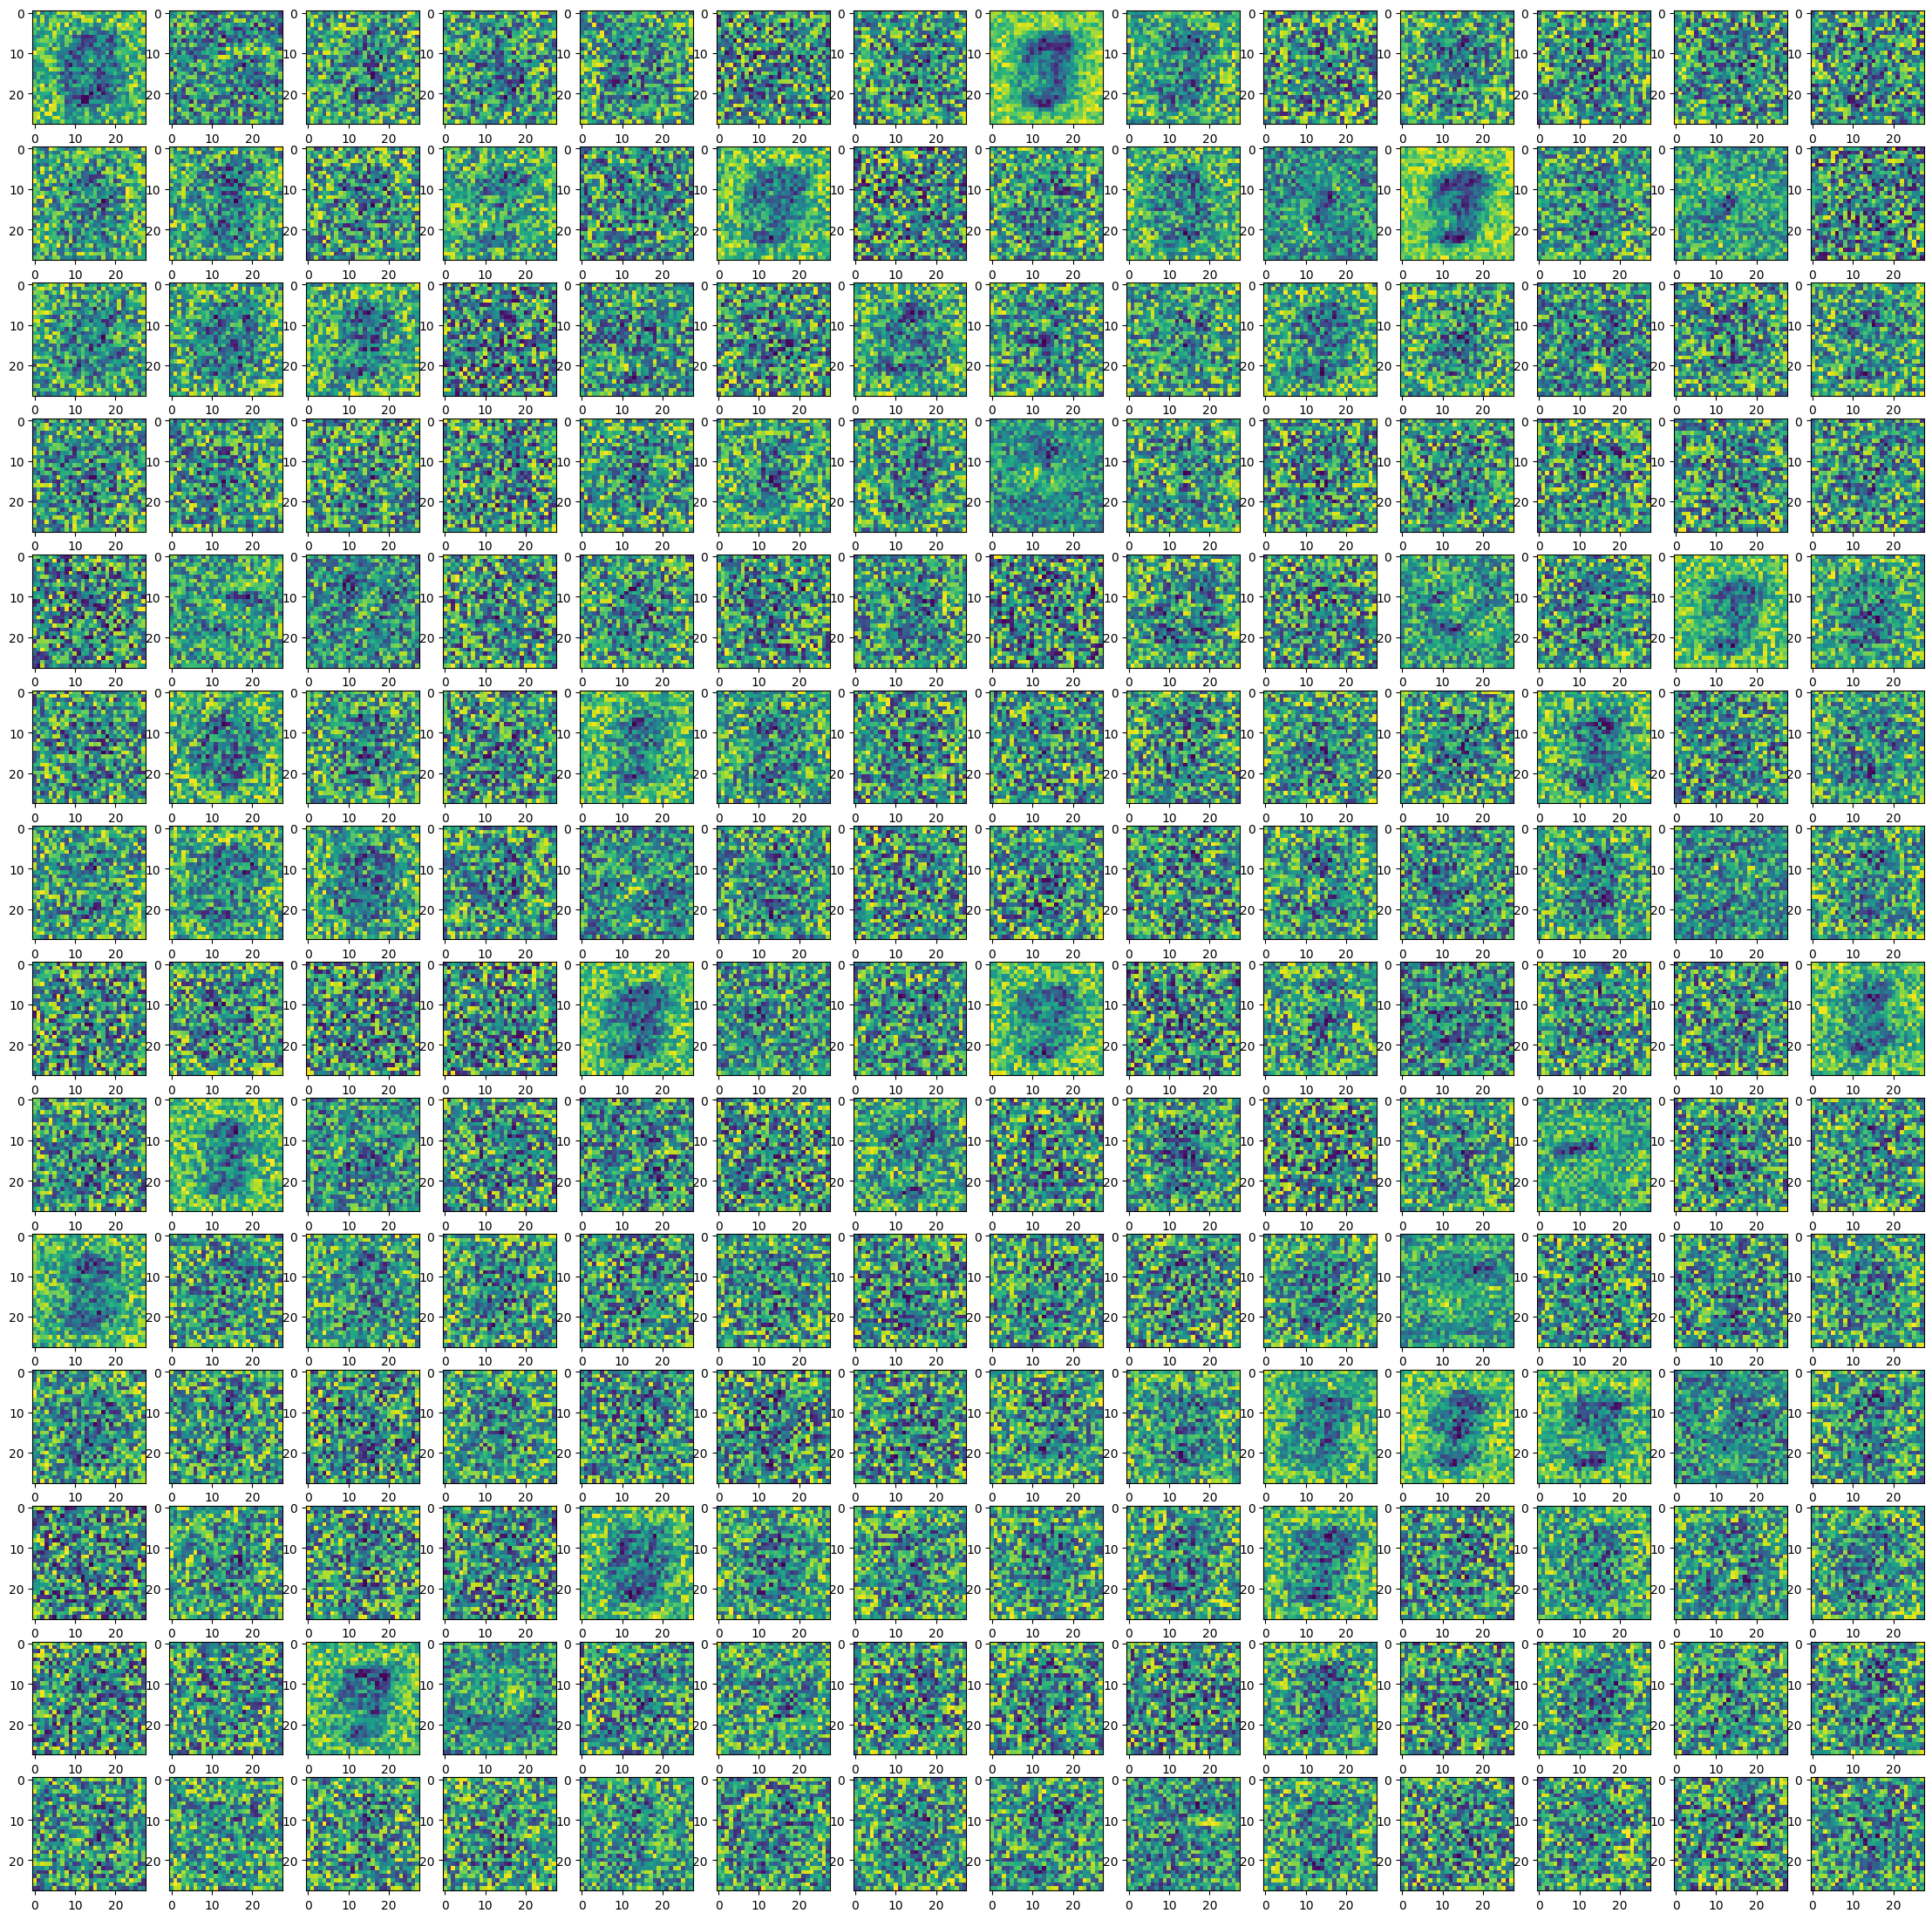

In [7]:
# %matplotlib widget
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (28, 28)
import math

fig, axs = plt.subplots(14, 14)
weights = model_state_dict['linear_relu_stack.0.weight'].numpy()
for i in range(196):
    x = i % 14
    y = math.floor(i / 14)
    axs[x, y].imshow(numpy.resize(weights[i], (28, 28)))
plt.show()
# im = ax.imshow(values)

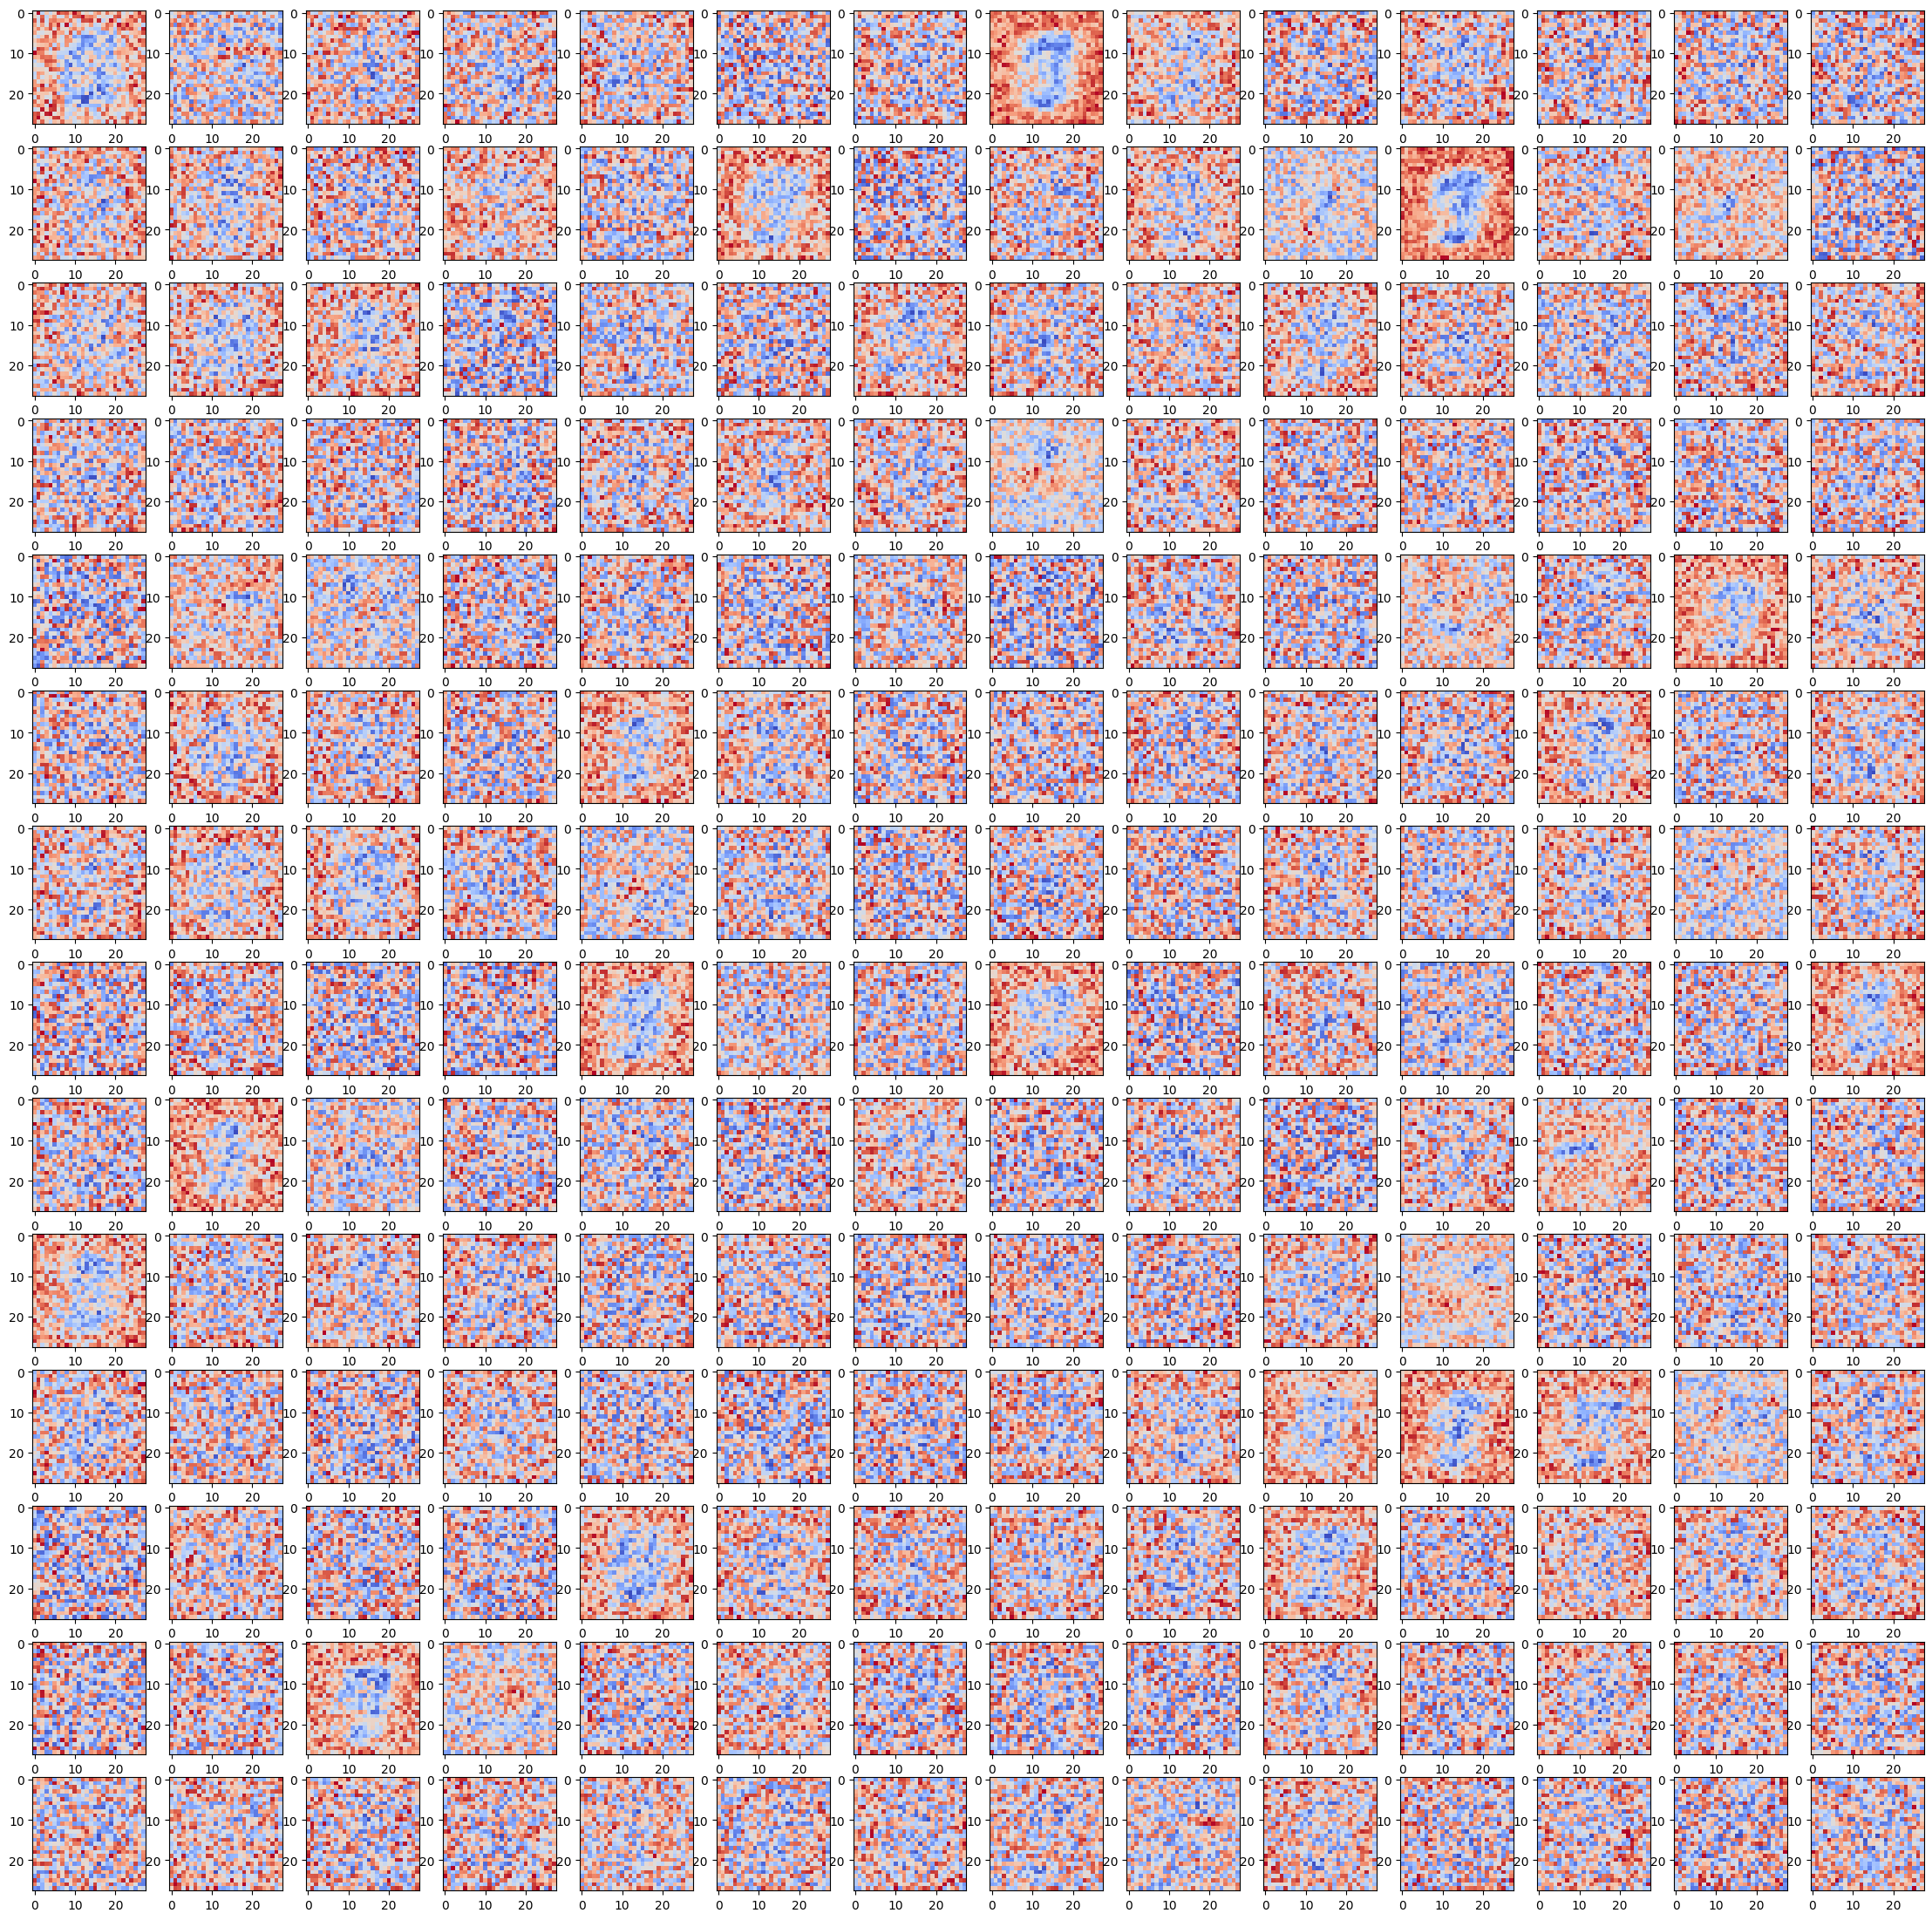

In [8]:
weights = model_state_dict['linear_relu_stack.0.weight'].numpy()
bias = model_state_dict['linear_relu_stack.0.bias'].numpy()
fig, axs = plt.subplots(14, 14)
for i in range(196):
    x = i % 14
    y = math.floor(i / 14)
    axs[x, y].imshow(numpy.resize(weights[i] + bias[i], (28, 28)), cmap="coolwarm")
plt.show()

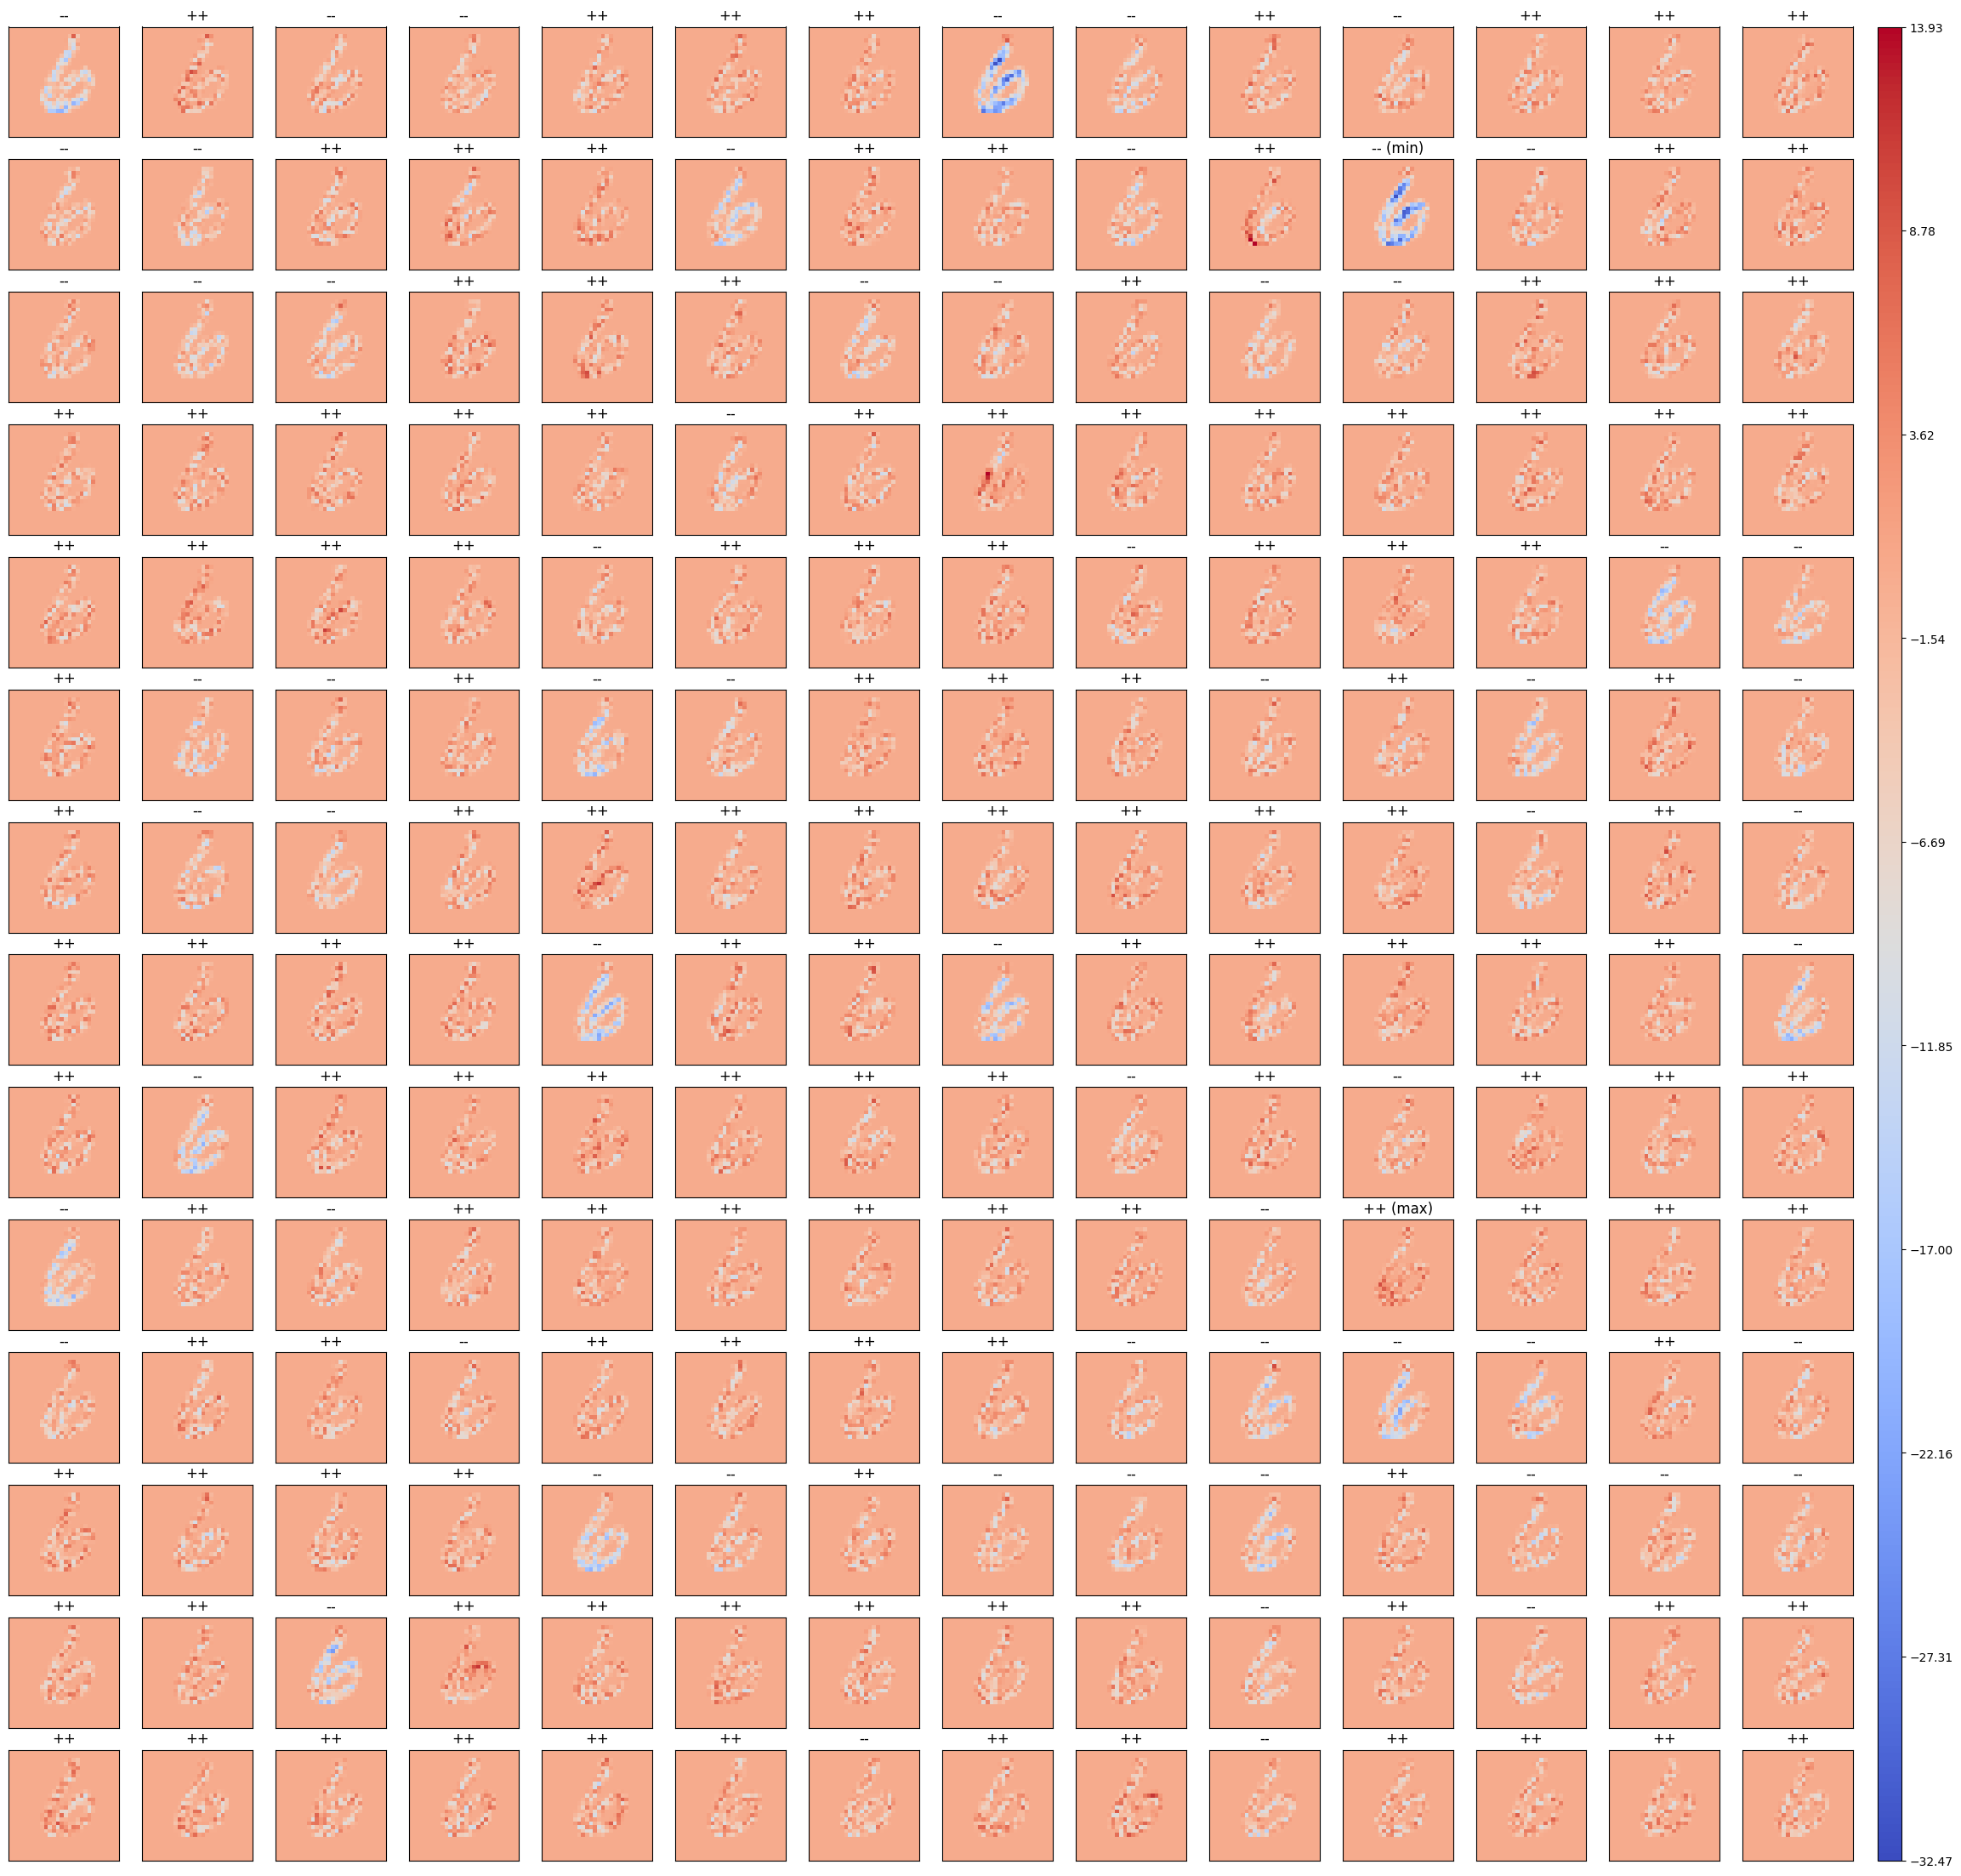

In [9]:
input_image = training_images[73]
weights = model_state_dict["linear_relu_stack.0.weight"].numpy()
# min_val, max_val = weights.min() * 255, weights.max() * 255
fig, axs = plt.subplots(14, 14)
max_result = -10000000000
min_result = 10000000000
max_result_x, max_result_y, max_result_x, max_result_y = 0, 0, 0, 0
results = weights * input_image
min_val = results.min()
max_val = results.max()
result_sums = numpy.sum(results, axis=1)
average_result_sum = numpy.mean(result_sums)
        
for i in range(196):
    x = i % 14
    y = math.floor(i / 14)
    axs[x, y].set_xticks([])
    axs[x, y].set_yticks([])
    result = numpy.resize(results[i], (28, 28))
    if result_sums[i] > max_result:
        max_result = result_sums[i]
        max_result_x = x
        max_result_y = y
    if result_sums[i] < min_result:
        min_result = result_sums[i]
        min_result_x = x
        min_result_y = y
    axs[x, y].imshow(result, cmap="coolwarm", vmin=min_val, vmax=max_val)
    if result_sums[i] > average_result_sum:
        axs[x, y].set_title("++")
    else:
        axs[x, y].set_title("--")

axs[max_result_x, max_result_y].set_title(axs[max_result_x, max_result_y].get_title() + " (max)")
axs[min_result_x, min_result_y].set_title(axs[min_result_x, min_result_y].get_title() + " (min)")

from matplotlib import cm
norm = plt.Normalize(vmin=min_val, vmax=max_val)
colorbar_ticks = numpy.linspace(min_val, max_val, 10)
sm = cm.ScalarMappable(cmap="coolwarm", norm=norm)
cax = fig.add_axes([0.91, 0.11, 0.01, 0.77])
cbar = fig.colorbar(sm, cax=cax)
cbar.set_ticks(colorbar_ticks)
plt.show()

### For each input neuron, find the largest (input pixel * weight[x]) + bias[x] and increment a counter for the weight index and input label pair 

In [10]:
weights = model_state_dict["linear_relu_stack.0.weight"].numpy()
bias = model_state_dict["linear_relu_stack.0.bias"].numpy()
stats = numpy.zeros((10, 196))

# foreach pixel offset, I want to know which weight produces the largest product, get the offset of said weight, and then increment its index on the stats counter for the corresponding class index
for z in range(784):
    # get all instances of specific pixel location
    # (60000, 784) -> (60000,)
    unique_spatial_pixels = training_images.T[z]
    # get weights specific to this pixel
    # (196, 784) -> (784, 196) -> (196,)
    specific_weights = weights.T[z]
    # generate set of all possible input * weights values for a given input neuron
    # (60000, 196)
    products = numpy.outer(unique_spatial_pixels, specific_weights) + bias
    # get max indicides for each image
    # (60000,)
    indices = products.argmax(axis=1)

    for y in range(60000):
        # Skip if input pixel is 0 - no clear max
        if training_images[y][z] != 0:
            label = training_labels[y]
            index = indices[y]
            stats[label][index] += 1

    print(f"\r{z+1}/{784}", end="")

784/784

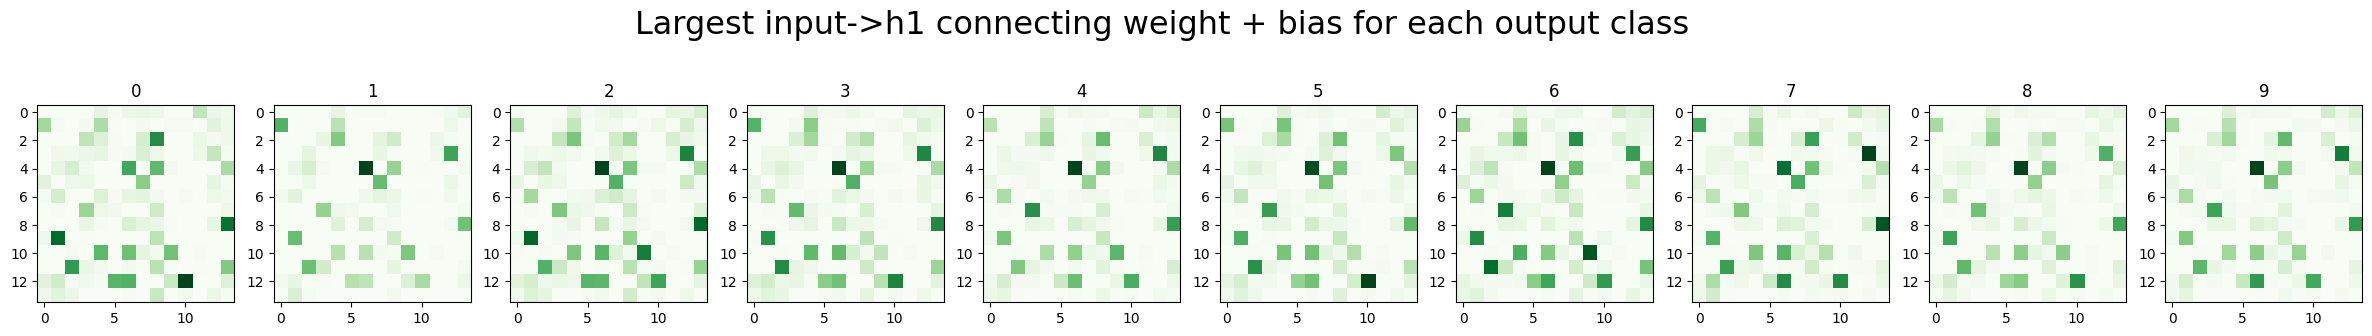

In [11]:
plt.rcParams["figure.figsize"] = (30, 4)
fig, axs = plt.subplots(1, 10)
for selected_class in range(10):
    stats_normalized_selected_class = (stats[selected_class] / stats[selected_class].max()) * 100
    stats_normalized_selected_class_average = (stats[selected_class].mean() / stats[selected_class].max()) * 100
    axs[selected_class].imshow(stats_normalized_selected_class.reshape(14, 14), cmap="Greens")
    axs[selected_class].set_title(selected_class)
fig.suptitle("Largest input->h1 connecting weight + bias for each output class", fontsize=23)
plt.show()

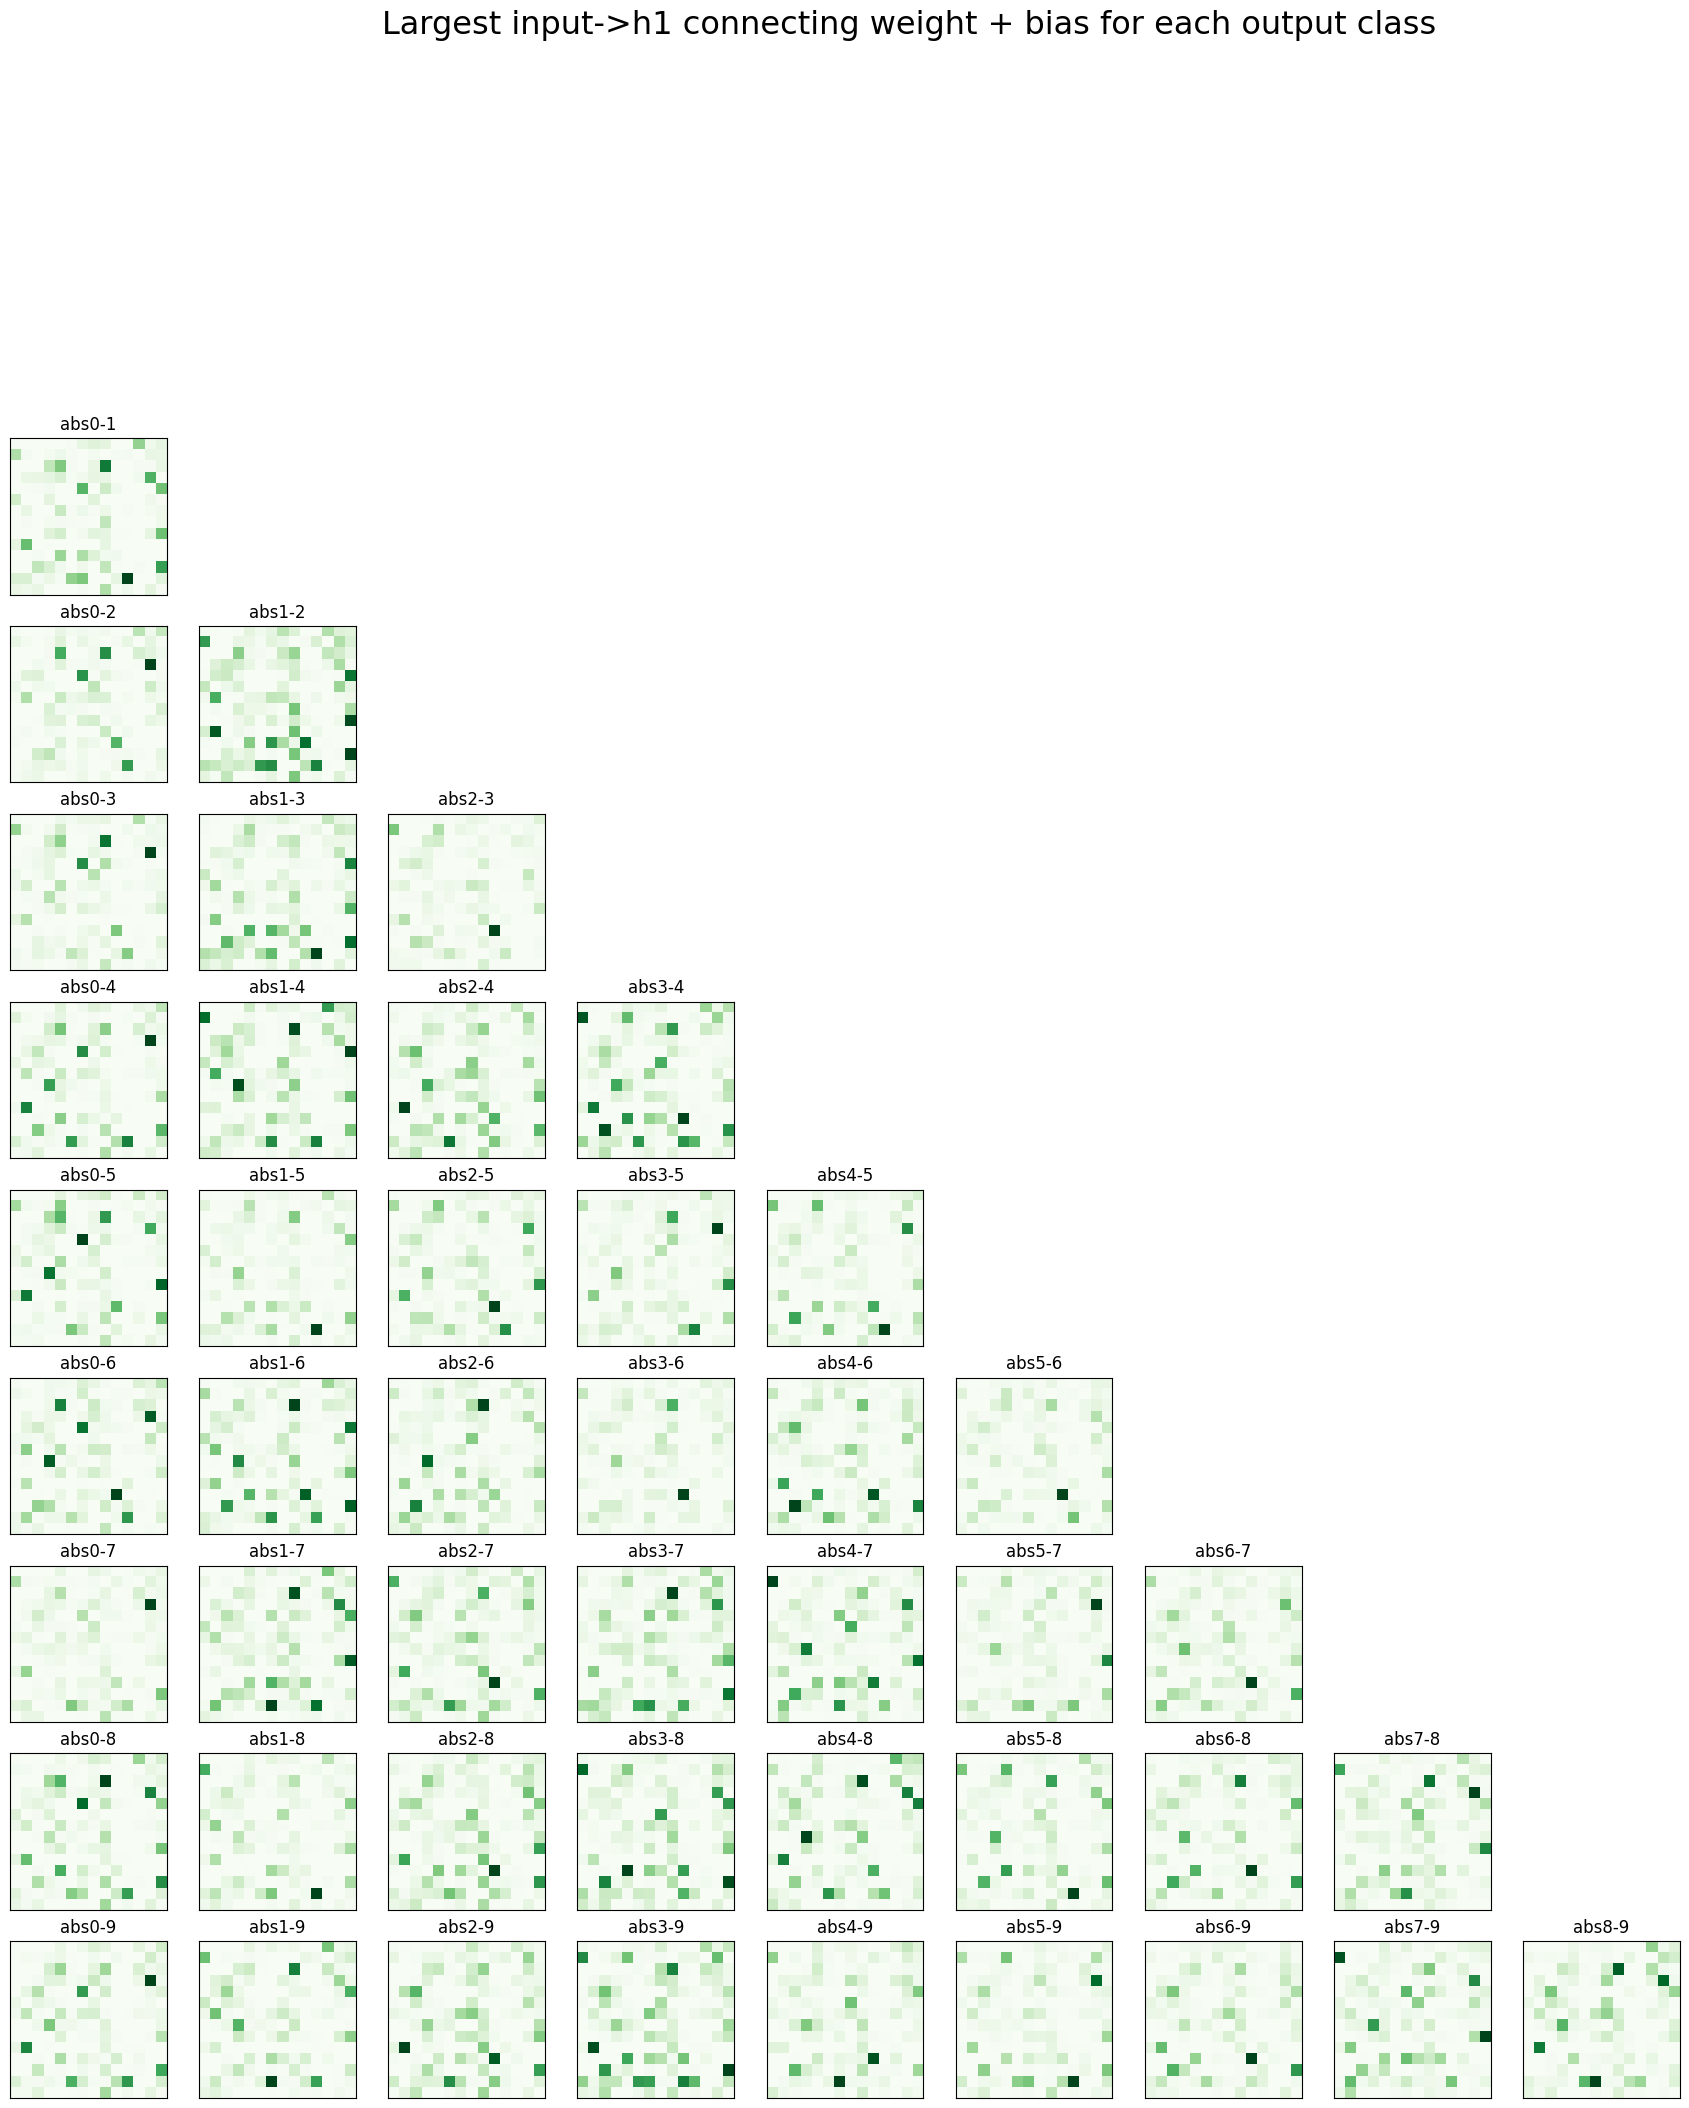

In [12]:
plt.rcParams["figure.figsize"] = (24, 24)
fig, axs = plt.subplots(10, 10)
unique_stats = numpy.zeros((10, 196))
stats_normalized_selected_class = numpy.zeros((10, 10, 196))

for selected_class in range(10):
    stats_normalized_selected_class[selected_class] = (stats[selected_class] / stats[selected_class].max()) * 100

for x in range(10):
    for y in range(0, x):
        axs[x, y].set_xticks([])
        axs[x, y].set_yticks([])
        abs = numpy.absolute(stats_normalized_selected_class[y][y] - stats_normalized_selected_class[x][x])
        axs[x, y].imshow(abs.reshape(14, 14), cmap="Greens")
        axs[x, y].set_title(f"abs{y}-{x}")
    for y in range(x, 10):
        axs[x, y].set_visible(False)
fig.suptitle("Largest input->h1 connecting weight + bias for each output class", fontsize=23)
plt.show()

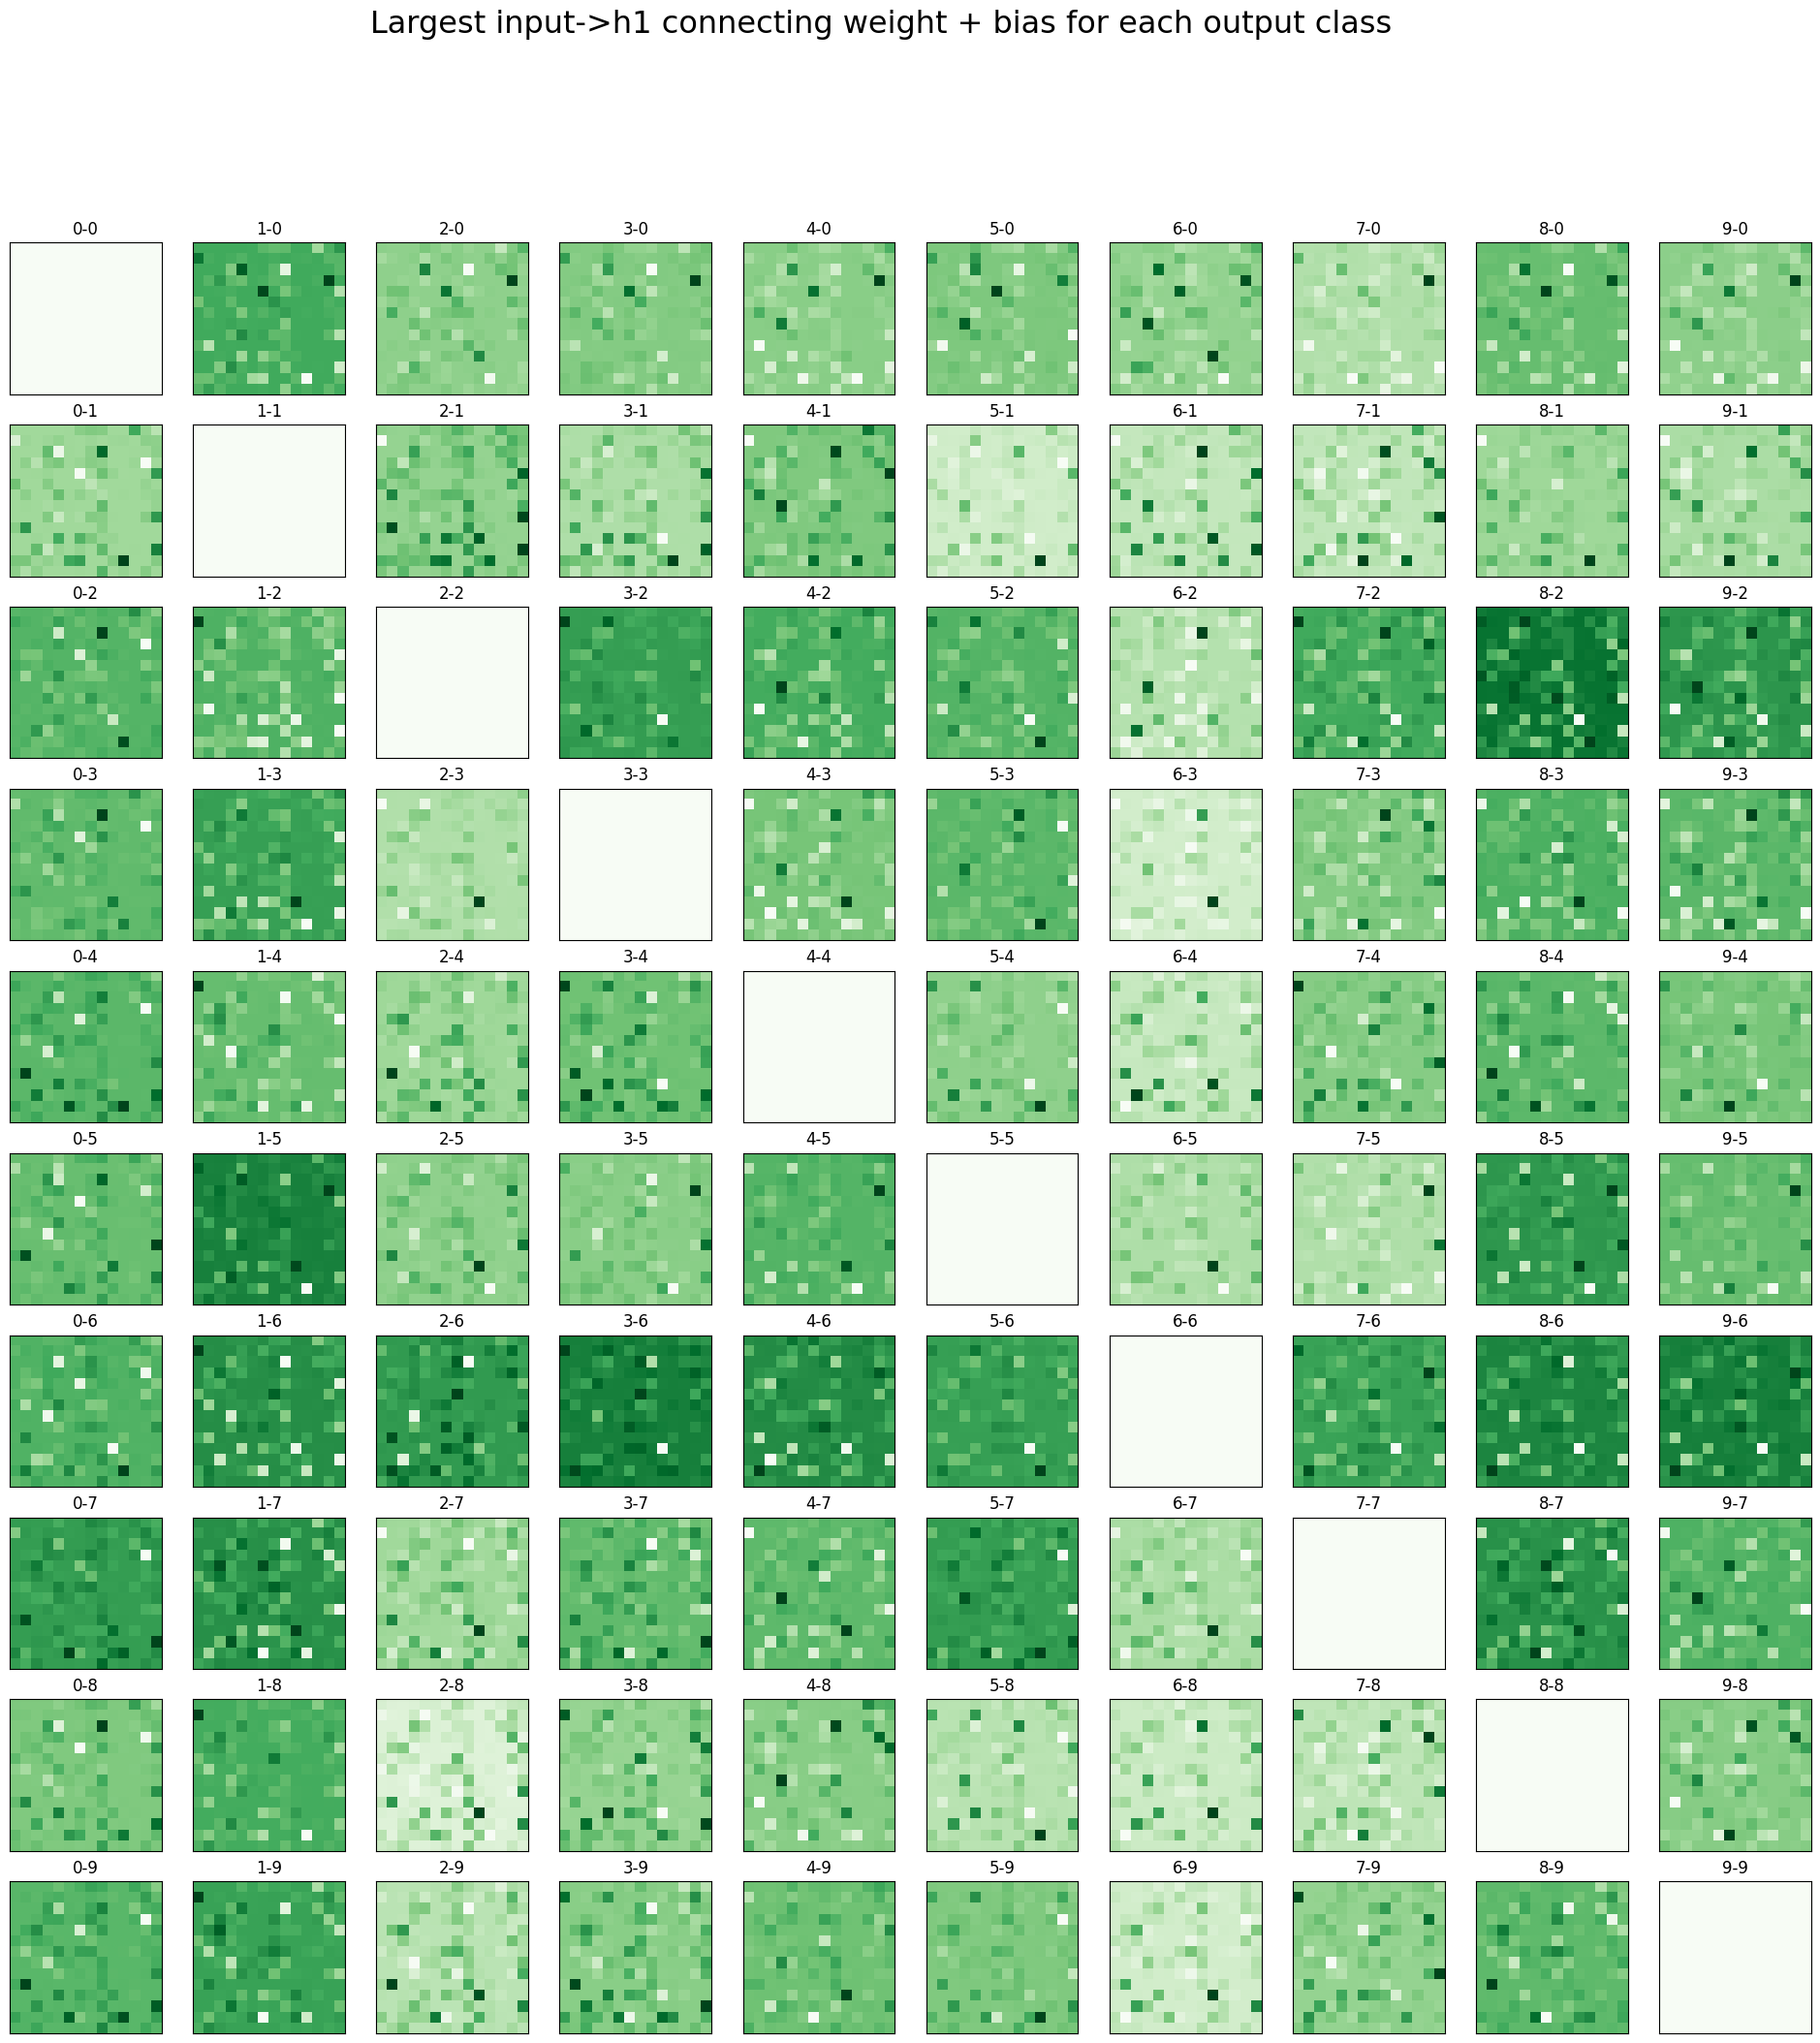

In [13]:
plt.rcParams["figure.figsize"] = (24, 24)
fig, axs = plt.subplots(10, 10)

for z in range(100):
    x = z % 10
    y = math.floor(z / 10)
    axs[x, y].set_xticks([])
    axs[x, y].set_yticks([])
    result = stats_normalized_selected_class[y][y] - stats_normalized_selected_class[x][x]
    axs[x, y].imshow(result.reshape(14, 14), cmap="Greens")
    axs[x, y].set_title(f"{y}-{x}")
fig.suptitle("Largest input->h1 connecting weight + bias for each output class", fontsize=23)
plt.show()

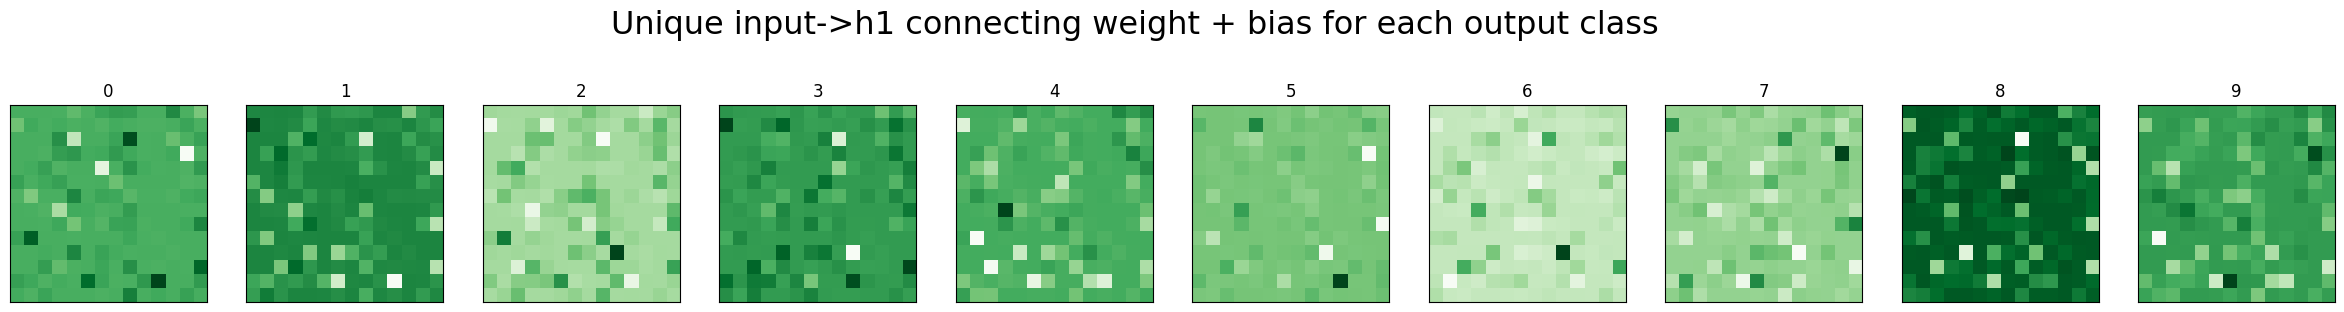

In [28]:
plt.rcParams["figure.figsize"] = (30, 4)
fig, axs = plt.subplots(1, 10)
for selected_class in range(10):
    stats_normalized_selected_class = (stats[selected_class] / stats[selected_class].max()) * 100

    # get the sum of all other classes
    complement_total = numpy.zeros_like(stats[selected_class])
    for z in range(10):
        if z != selected_class:
            complement_total += stats[z]
    complement_total = (complement_total / complement_total.max()) * 100
    result = (stats_normalized_selected_class - complement_total) / 2    
    axs[selected_class].set_xticks([])
    axs[selected_class].set_yticks([])
    axs[selected_class].imshow(result.reshape(14, 14), cmap="Greens")
    axs[selected_class].set_title(selected_class)
fig.suptitle("Unique input->h1 connecting weight + bias for each output class", fontsize=23)
plt.show()

### Calculating RoI of MNIST dataset

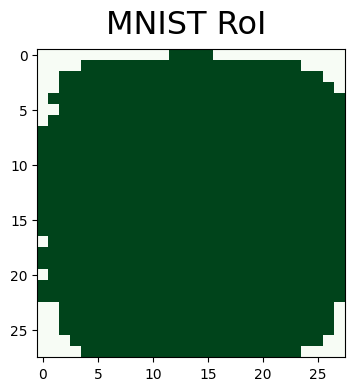

In [15]:
plt.rcParams["figure.figsize"] = (4, 4)
image_sum = numpy.zeros(784)
for z in range(60000):
    image_sum += training_images[z]
result = numpy.array(image_sum != 0, dtype=int).reshape(28, 28)
plt.suptitle("MNIST RoI", fontsize=23)
plt.imshow(result, cmap="Greens")
plt.show()

### Output the image that produces the highest sum

196/196

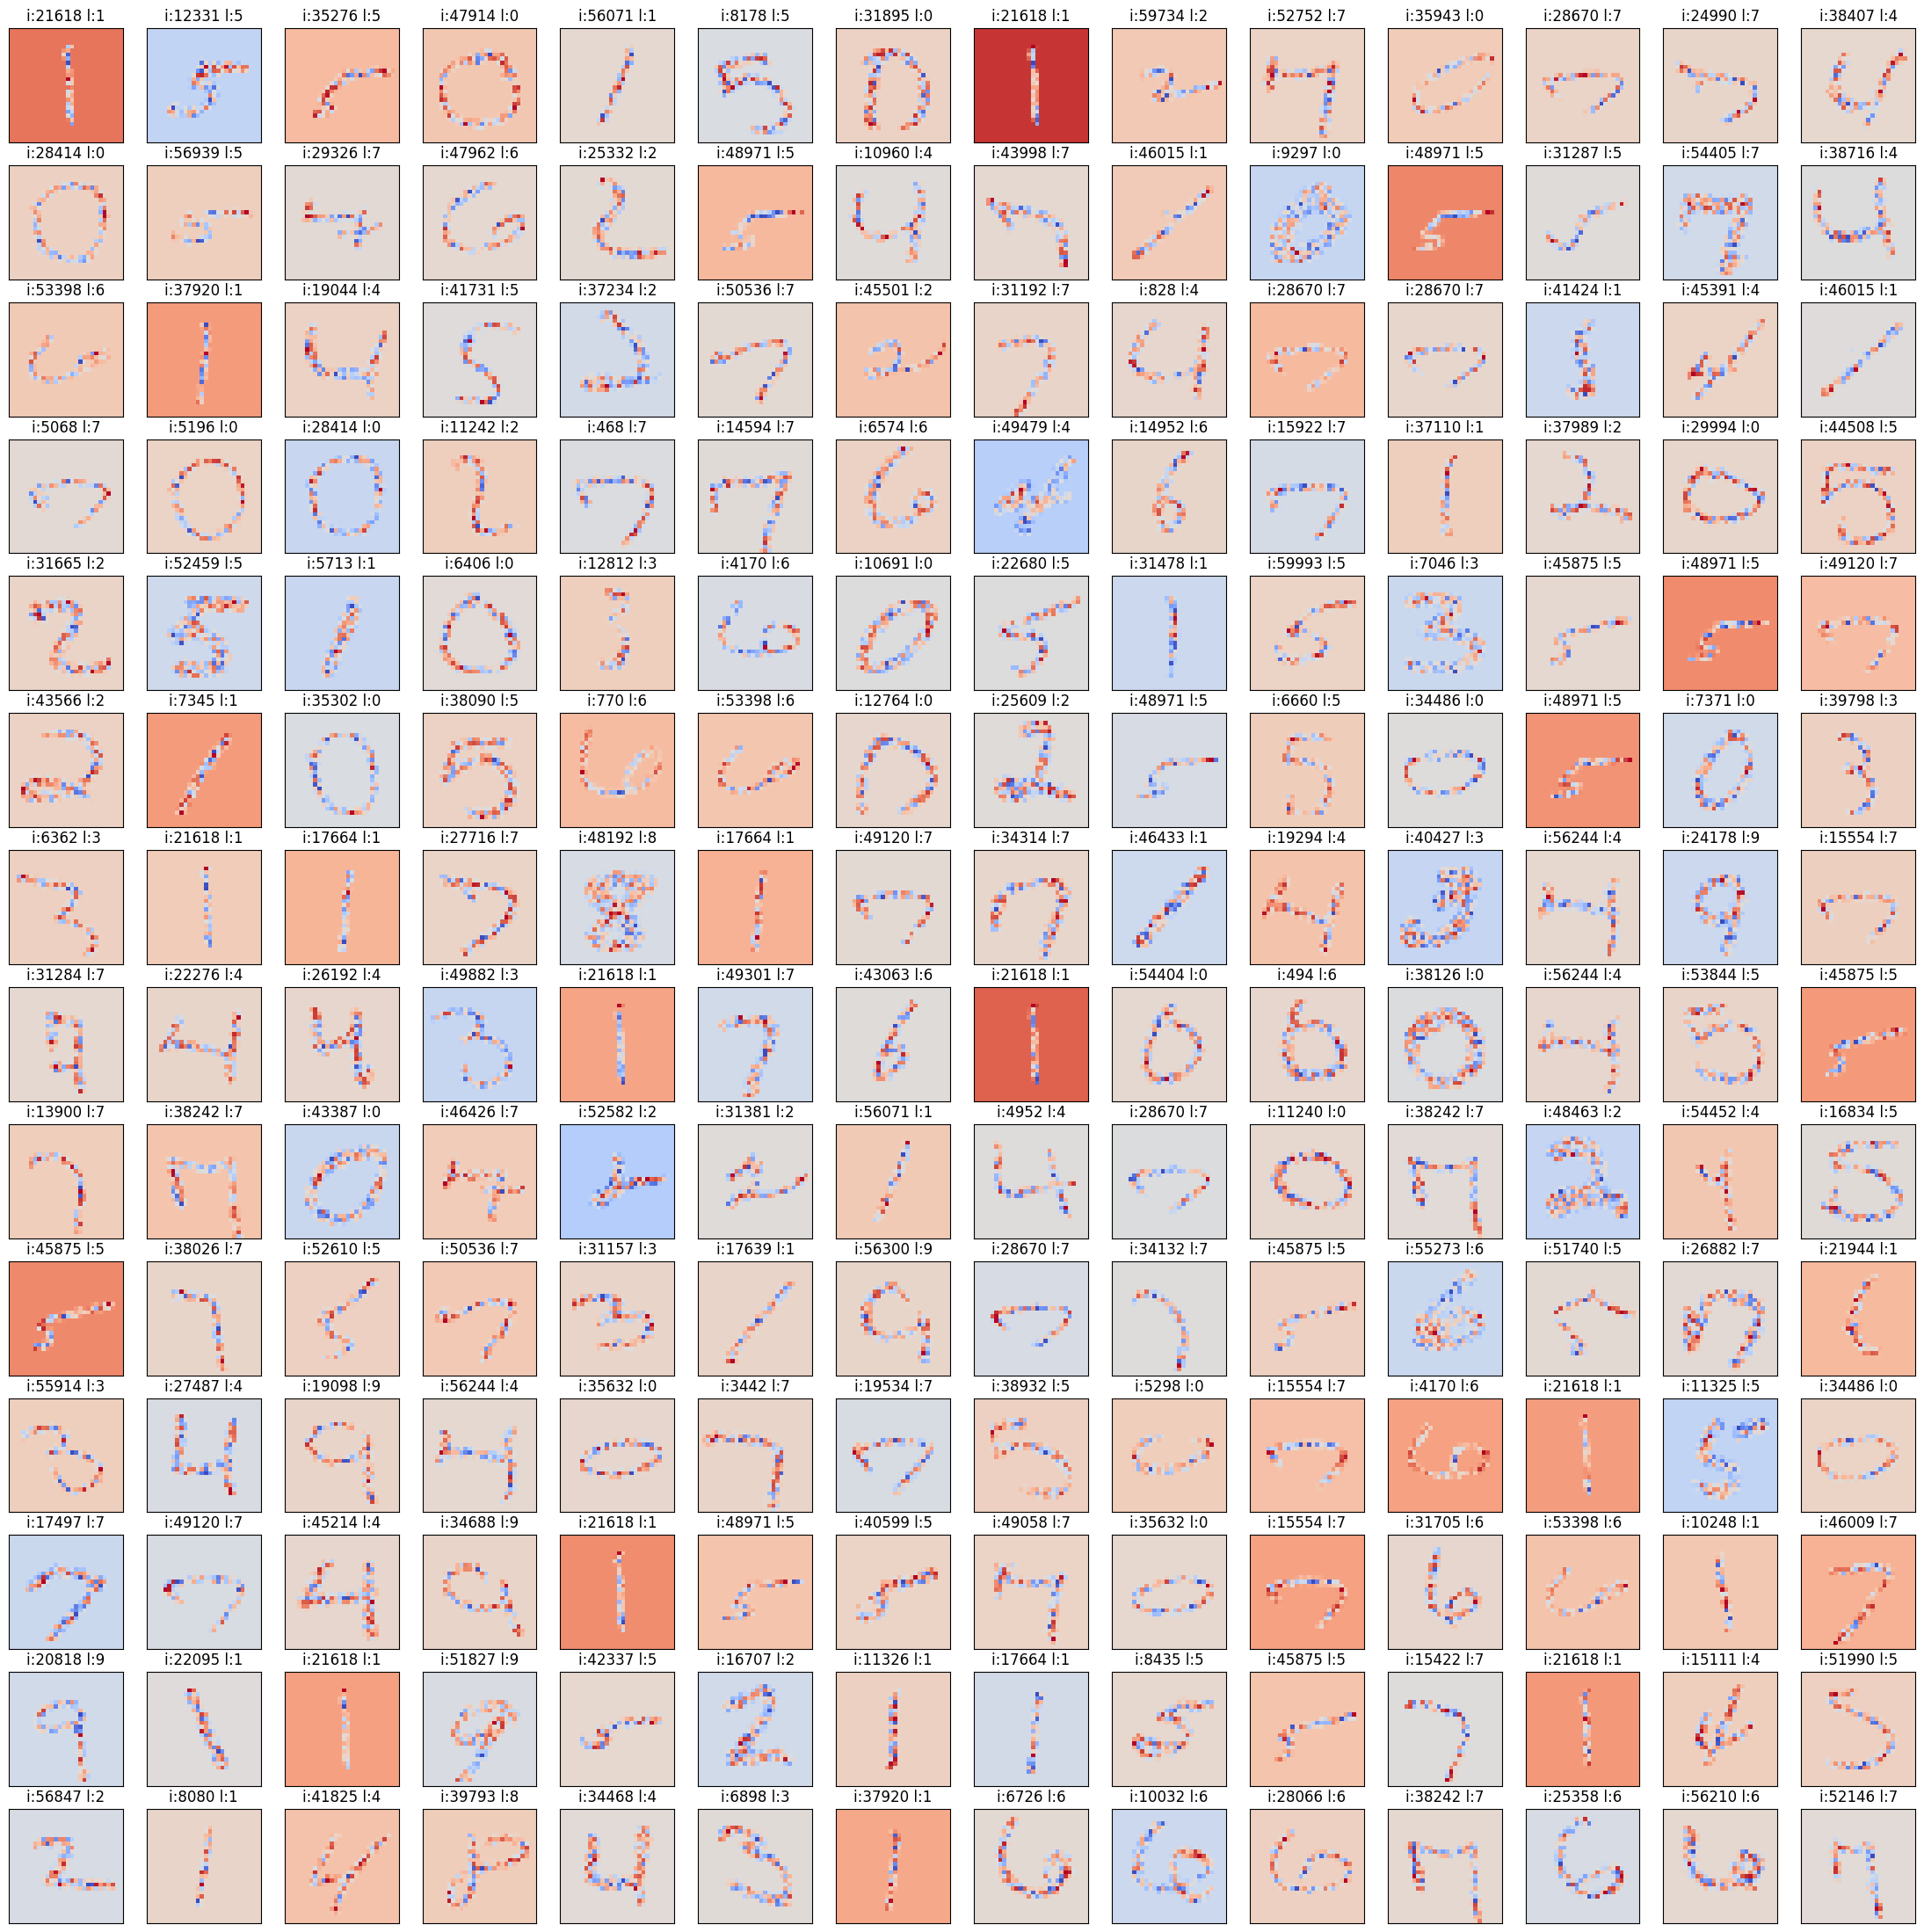

In [39]:
plt.rcParams["figure.figsize"] = (28, 28)
weights = model_state_dict['linear_relu_stack.0.weight'].numpy()
bias = model_state_dict['linear_relu_stack.0.bias'].numpy()
fig, axs = plt.subplots(14, 14)
for i in range(196):
    x = i % 14
    y = math.floor(i / 14)

    z_save = -1
    max = numpy.zeros_like(weights[i])
    max_sum = -100000000000
    for z in range(60000):
        temp = (training_images[z] * weights[i]) + bias[i]
        temp_sum = temp.sum()
        if temp_sum > max_sum:
            max = temp
            max_sum = temp_sum
            z_save = z

    axs[x, y].set_xticks([])
    axs[x, y].set_yticks([])
    axs[x, y].set_title(f"i:{z_save} l:{training_labels[z_save]}")
    axs[x, y].imshow(numpy.resize(max, (28, 28)), cmap="coolwarm")
    print(f"\r{i+1}/{196}", end="")
plt.show()